In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import os
import sys
import time
import scipy
from scipy import signal
sys.path.append("/usr/lib/python2.7/dist-packages")
import nibabel as nib

In [2]:
imgs = np.zeros((320,312,9))
cases = np.array([7,55,58,59,61,75,82,92,98,99,123,558,561,562,563,564,565,566,568,569,
         570,571,576,578,579,581,582,583,585,590,591,593,597,593,597,598,599])
#43,68,
num = 9#cases.shape[0]
#imgs = np.zeros((380,1300,num))


for i in range(1,num+1):
    #print(cases[i])
    fileniiseg = 'train_im' + str(i) + '.nii.gz'
    #fileniiseg = str(cases[i]) + '.nii.gz'
    img_filename = os.path.join('/home/heinrich/notebooks/',fileniiseg)
    #img_filename = os.path.join('/home/heinrich/MRT1_wb/',fileniiseg)
    img = nib.load(img_filename)
    data_img = img.get_data()
    data_img = np.flipud(np.fliplr((np.clip(data_img,0,1500.0)/1500.0))).transpose(1,0)#.transpose(0,2,1)
    imgs[:,:,i-1] = data_img#[3:383,0:1300,0]


In [3]:
#affine = np.diag([1, 2, 3, 1])
#array_img = nib.Nifti1Image(imgs,affine)
#nib.save(array_img,'/home/heinrich/MRT1_wb/MRT_image_stack.nii.gz')    



(0, 219, 23)
(64, 64)


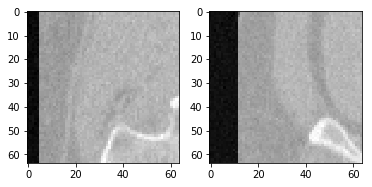

0


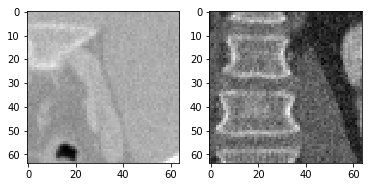

In [19]:
img_test = imgs[:,:,8]
num = 4096*8
rand_offx = np.random.randint(10,170,size=num)
rand_offy = np.random.randint(10,170,size=num)
rand_label = np.random.randint(0,4,size=num)
rand_jitx = np.random.randint(4,8,size=num)
rand_jity = np.random.randint(4,8,size=num)

rand_img = np.random.randint(0,8,size=num)


dataA = torch.FloatTensor(num,1,64,64)
dataB = torch.FloatTensor(num,1,64,64)

num_test = 1024
dataA_test = torch.FloatTensor(num_test,1,64,64)
dataB_test = torch.FloatTensor(num_test,1,64,64)

label_test = torch.LongTensor(num_test)


label_data = torch.LongTensor(num)

for i in range(num):
    x2 = rand_offx[i]+rand_jitx[i]
    y2 = rand_offy[i]+rand_jity[i]
    if(rand_label[i]%2==0):
        x2 += 72
    else:
        y2 += 72
    patch1 = imgs[rand_offx[i]:rand_offx[i]+64,rand_offy[i]:rand_offy[i]+64,rand_img[i]] + np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5
    patch2 = imgs[x2:x2+64,y2:y2+64,rand_img[i]] + np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5
    if(rand_label[i]<2):
        patch_temp = patch2
        patch2 = patch1
        patch1 = patch_temp
    dataA[i,0,:,:] = torch.from_numpy(patch1).float()
    dataB[i,0,:,:] = torch.from_numpy(patch2).float()
    label_data[i] = rand_label[i]#torch.from_numpy().long()
    if(i<num_test):
        patch1_test = img_test[rand_offx[i]:rand_offx[i]+64,rand_offy[i]:rand_offy[i]+64]+ np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5
        patch2_test = img_test[x2:x2+64,y2:y2+64] + np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5
        if(rand_label[i]<2):
            patch_temp = patch2_test
            patch2_test = patch1_test
            patch1_test = patch_temp
        dataA_test[i,0,:,:] = torch.from_numpy(patch1_test).float()
        dataB_test[i,0,:,:] = torch.from_numpy(patch2_test).float()
        label_test[i] = rand_label[i]#torch.from_numpy().long()


print((rand_label[i],x2,y2))
#print((rand_offx[0],rand_offy[0]))
#print((rand_jitx[0],rand_jity[0]))

print(patch2.shape)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(patch1,'gray')
ax2.imshow(patch2,'gray')
plt.show()


print(label_test[num_test-1])
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(patch1_test,'gray')
ax2.imshow(patch2_test,'gray')
plt.show()

In [20]:
class ContextNet(nn.Module):
    def __init__(self):
        super(ContextNet, self).__init__()
        feat = 16
        self.conv1 = nn.Conv2d(1, feat, 7, dilation=2)
        self.bn1 = nn.BatchNorm2d(feat)
        self.conv2 = nn.Conv2d(feat, feat*2, 5)
        self.bn2 = nn.BatchNorm2d(feat*2)
        self.conv3 = nn.Conv2d(feat*2, feat*4, 5, dilation=2)
        self.bn3 = nn.BatchNorm2d(feat*4)
        
        self.conv4 = nn.Conv2d(feat*4, feat*8, 3)
        self.bn4 = nn.BatchNorm2d(feat*8)
        self.conv5 = nn.Conv2d(feat*8, feat*8, 3)
        self.bn5 = nn.BatchNorm2d(feat*8)
        self.conv6 = nn.Conv2d(feat*8, feat*16, 1)
        self.bn6 = nn.BatchNorm2d(feat*16)
     

       # self.conv4 = nn.Conv2d(feat*2, feat*4, 3)
       # self.bn4 = nn.BatchNorm2d(feat*4)
       # self.conv5 = nn.Conv2d(feat*4, feat*4, 1)
       # self.bn5 = nn.BatchNorm2d(feat*4)
       # self.conv6 = nn.Conv2d(feat*4, feat*8, 2)
       # self.bn6 = nn.BatchNorm2d(feat*8)

        self.conv7a = nn.Conv2d(feat*16, feat*2, (2,1))
        self.bn7 = nn.BatchNorm2d(feat*2)

        self.conv7b = nn.Conv2d(feat*2, 4, 1)


        self.adapt2 = nn.AdaptiveAvgPool2d((1,1))
        self.max2 = nn.MaxPool2d((2, 2))
        self.avg2 = nn.AvgPool2d((2, 2))

        
        

    def forward(self, inputA, inputB):
        x0a = inputA
        x1a = self.max2(F.relu(self.bn1(self.conv1(x0a))))
        x2a = F.relu(self.bn2(self.conv2(x1a)))
        x3a = self.max2(F.relu(self.bn3(self.conv3(x2a))))
        x4a = F.relu(self.bn4(self.conv4(x3a)))
        x5a = F.relu(self.bn5(self.conv5(x4a)))
        x6a = self.conv6(x5a)
        x7a = self.adapt2(x6a)
        x0b = inputB #self.avg2
        x1b = self.max2(F.relu(self.bn1(self.conv1(x0b))))
        x2b = F.relu(self.bn2(self.conv2(x1b)))
        x3b = self.max2(F.relu(self.bn3(self.conv3(x2b))))
        x4b = F.relu(self.bn4(self.conv4(x3b)))
        x5b = F.relu(self.bn5(self.conv5(x4b)))
        x6b = self.conv6(x5b)
        x7b = self.adapt2(x6b)
        #y_out = self.conv7a(torch.cat((x7a,x7b),dim=2))
        y1 = F.relu(self.bn7(self.conv7a(torch.cat((x7a,x7b),dim=2))))
        y_out = self.conv7b(y1)
        return y_out, x6a, x6b
    

In [21]:
inputA = Variable(dataA[0:16,:,:,:])
feat = 16
mconv1 = nn.Conv2d(1, feat, 5, stride=2, dilation=2)
A1 = mconv1(inputA)
mconv1 = nn.Conv2d(1, feat, 5, stride=1, dilation=2)
A1 = mconv1(inputA)
print(A1.size())


torch.Size([16, 16, 56, 56])


In [22]:
net = ContextNet()
idx_epoch = torch.randperm(4096).view(16,256)
inputA = Variable(dataA[0:16,:,:,:])
inputB = Variable(dataB[0:16,:,:,:])
print(inputA.size())
output = net(inputA,inputB)
print(output[0].size())
print(output[1].size())



torch.Size([16, 1, 64, 64])
torch.Size([16, 4, 1, 1])
torch.Size([16, 256, 3, 3])


In [8]:
#def imageEpoch(outputs, epoch):
#    string1 = 'imgdenoise'+`epoch`+'.jpg'
#    im1 = np.transpose(np.clip(outputs[0,0,:,:].data.cpu().numpy(),-1,.7))
#    plt.imshow(np.fliplr(np.flipud(im1)),'gray')
#    plt.savefig(string1)
#    plt.show()
#    
#img_test = img_test_gt + np.random.randn(312,320)*0.10
#input_test = Variable(torch.from_numpy(img_test.astype('float32')).view(1,1,312,320)).cuda()
#imageEpoch(input_test, 99)
#test_gt = Variable(torch.from_numpy(img_test.astype('float32')).view(1,1,312,320)).cuda()
#imageEpoch(test_gt, 199)

In [25]:
#training, weight initialisation
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        init.xavier_normal(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0.0)
net.apply(init_weights)
net.cuda()
#loss criterion and SGD optimizer 
criterion = nn.CrossEntropyLoss()#
optimizer = optim.Adam(net.parameters(), lr=0.0005)#lr=0.02, momentum=0.9)
#optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.95)#lr=0.02, momentum=0.9)

#scheduler = optim.ExponentialLR(optimizer, gamma=0.8)
def exp_lr_scheduler(optimizer, epoch, lr_decay=0.85, lr_decay_epoch=1):
    """Decay learning rate by a factor of lr_decay every lr_decay_epoch epochs"""
    if epoch % lr_decay_epoch:
        return optimizer
    
    for param_group in optimizer.param_groups:
        param_group['lr'] *= lr_decay
    return optimizer


#torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)[source]
#Set the learning rate of each parameter group to the initial lr decayed by gamma every epoch.
#When last_epoch=-1, sets initial lr as lr.
run_loss = np.zeros(15)
time_all = 0.0
#training epochs
for epoch in range(15):
    optimizer=exp_lr_scheduler(optimizer, epoch)
    run_loss[epoch] = 0.0
    idx_epoch = torch.randperm(num).view(16,-1)
    #mini-batches
    net.train()
    for iter in range(num/16):
        idx_iter = idx_epoch[:,iter]
        optimizer.zero_grad() 
        #forward path and loss
        inputA = Variable(dataA[idx_iter,:,:,:]).cuda()
        inputB = Variable(dataB[idx_iter,:,:,:]).cuda()

        labels = Variable(label_data[idx_iter]).view(-1,1,1).cuda()
        outputs = net(inputA,inputB)
        loss = criterion(outputs[0], labels)
        #backward path and weight updates
        loss.backward()
        optimizer.step()
        run_loss[epoch] += loss.data[0]
    net.eval()
    t0 = time.time()
    inputA = Variable(dataA_test).cuda()
    inputB = Variable(dataB_test).cuda()
    output_test = net(inputA,inputB)   
    torch.cuda.synchronize()
    time_all += (time.time() - t0) * 0.1
    _, argmax = torch.max(output_test[0][:,:,0,0],dim=1)
    accuracy = torch.mean(torch.eq(argmax.data.cpu(),label_test).float())
    print(accuracy)

    #imageEpoch(output_test, epoch)
    print(run_loss[epoch]*0.125)
    #scheduler.step()
print('time per inference',time_all)

torch.save(net.state_dict(), 'context_net8.pth')

0.7587890625
262.33245052
0.85546875
129.708580879
0.8896484375
60.6518990463
0.927734375
32.9696262204
0.935546875
21.4137765858
0.9287109375
14.2529260637
0.9296875
10.4920176542
0.927734375
8.61367210932
0.9365234375
6.53981454764
0.943359375
5.0597644588
0.958984375
4.41161119565
0.939453125
3.96628516843
0.9306640625
3.51258673379
0.9521484375
2.41826980631
0.9482421875
2.3148360718
('time per inference', 0.11512029170989992)


In [26]:
#torch.load(net.state_dict(), 'context_net.pth')
#net.state_dict() = torch.load('context_net.pth')
model = torch.load('context_net8.pth')
net = ContextNet()
net.load_state_dict(model)


In [27]:
#net2 = net
#net.apply(init_weights)
net.cuda()
net.eval()
#net = net2
import scipy.io as io



dataAim = np.expand_dims(np.expand_dims(imgs[:,:,1], axis=0), axis=0)
dataBim = np.expand_dims(np.expand_dims(img_test, axis=0), axis=0)

inputA = Variable(torch.from_numpy(dataAim).float().cuda())
inputB = Variable(torch.from_numpy(dataBim).float().cuda())


p2d = (26, 26, 26, 26) # pad last dim by (1, 1) and 2nd to last by (2, 2)
inputA = F.pad(inputA, p2d, "constant", 0)
inputB = F.pad(inputB, p2d, "constant", 0)


outputs = net(inputA,inputB)

outputA = F.upsample(outputs[1],scale_factor=4)
outputB = F.upsample(outputs[2],scale_factor=4)



print(outputs[1].size())
print(outputA.size())



torch.Size([1, 256, 80, 78])
torch.Size([1, 256, 320, 312])


torch.Size([16, 1, 7, 7])


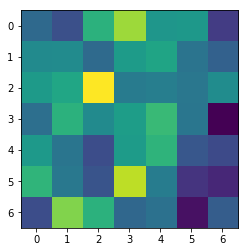

In [28]:
print(net.conv1.weight.size())
filter = net.conv1.weight.data[5,0,:,:].cpu()#net.conv1.weight.data.cpu().permute(2,3,0,1).contiguous().view(7,7*16)
plt.imshow(filter.numpy())
plt.show()

In [43]:
del model
del loss

In [31]:


a = {}
a['outputA'] = outputs[1][0,:,:].data.cpu().numpy()
a['outputB'] = outputs[2][0,:,:].data.cpu().numpy()
a['imageA'] = imgs[:,:,1]
a['imageB'] = img_test
io.savemat('context_learning8.mat',a)

[130 271]
torch.Size([1, 320, 312])
(121, 198)
torch.Size([320, 312])


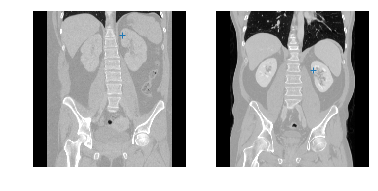

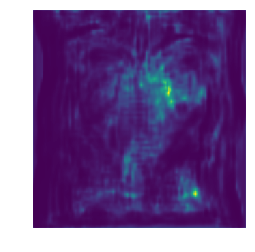

In [53]:
x = 104
y = 250#132#

data=scipy.io.loadmat('trainingpts.mat')
train_pts = data.get('train_pts')
train_nu = 1
train_key = 20#16#15#11#22# ##12
print(train_pts[train_key,:,train_nu])
y = 320-train_pts[train_key,1,train_nu]
x = 312-train_pts[train_key,0,train_nu]

avg3 = nn.AvgPool2d((5,5), stride=(1,1), padding=(2,2), count_include_pad=False)

accum = 2
p2dB = (accum, accum, accum, accum) # pad last dim by (1, 1) and 2nd to last by (2, 2)
outputB_pad = F.pad(outputB, p2dB, "constant", 0)

diff = Variable(torch.zeros(1,320,312).float().cuda())
for i in range(-accum,accum+1):
    for j in range(-accum,accum+1):
        diff += (torch.mean((torch.abs(outputA[:,:,y+i:y+1+i,x+j:x+1+j]-outputB_pad[:,:,i+accum:320+i+accum,j+accum:312+j+accum])),dim=1))
#diff = (torch.mean((torch.abs(outputA[:,:,y:y+1,x:x+1]-outputB)),dim=1))

factor = 10.0/(2.0*accum+1.0)/(2.0*accum+1.0)        
print(diff.size())
diff_np = diff[0,:,:].cpu().data.numpy()
xy_sim = np.unravel_index(diff_np.argmin(), diff_np.shape)

print(xy_sim)

diff = F.softmax(-diff.view(-1)*factor).view(320,312)
diff_np = diff.cpu().data.numpy()


print(diff.size())
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(imgs[:,:,1],'gray')
#plt.hold(True)
ax1.plot(x,y,'+')
ax1.axis('off')
ax2.imshow(img_test,'gray')
ax2.plot(xy_sim[1],xy_sim[0],'+')
ax2.axis('off')
plt.show()

plt.imshow(diff_np)
plt.axis('off')
plt.show()


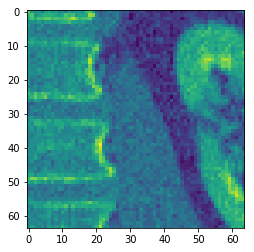

Variable containing:
 4.1884 -0.1537 -1.6073 -1.2401
-0.7186  2.2046  2.5033 -2.5969
 6.5827 -1.4788 -4.7061 -0.8134
 3.0219  2.6725 -0.9966 -2.4825
 2.0711  0.2973 -1.3604 -1.1730
 5.3604  0.6854 -4.2708 -2.1669
 0.4383 -0.4456  0.0319 -0.6658
-2.3772 -2.9365  4.3204  1.8235
-3.3408  0.6512  5.5101 -2.1401
-0.4950  5.8037  0.6120 -4.7652
 0.7193  1.4475  1.0068 -2.2492
-1.7639 -0.9932  3.1222 -0.3180
-0.0866  6.6801  0.2331 -6.0454
-3.1372 -0.7854  5.4775 -0.9160
 1.0937  6.2899 -1.1322 -5.3087
 5.2649  0.4820 -4.3316 -1.9659
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]


  2
 12
  8
  7
[torch.LongTensor of size 4]



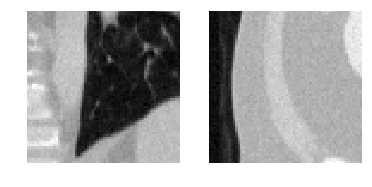

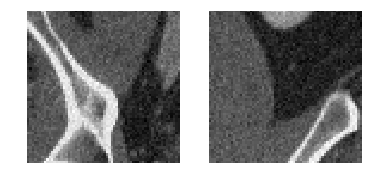

In [112]:
#puzzle (centre?)
dataAp = torch.FloatTensor(16,1,64,64)
dataBp = torch.FloatTensor(1,1,64,64)

patch1_test = img_test[100:100+64,150:150+64] + np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5
dataBp[0,0,:,:] = torch.from_numpy(patch1_test).float()

rand_offx = np.random.randint(16,210,size=16)
rand_offy = np.random.randint(16,210,size=16)

count = 0
for i in range(16):
    patch1_test = img_test[rand_offx[i]:rand_offx[i]+64,rand_offy[i]:rand_offy[i]+64] + np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5
    dataAp [i,0,:,:] = torch.from_numpy(patch1_test).float()

plt.imshow(dataBp[0,0,:,:].numpy())
plt.show()

dataBp = dataBp.expand(16,1,64,64)
output = net(Variable(dataBp.cuda()),Variable(dataAp.cuda()))
output_soft = F.softmax(output[0][:,:,0,0])
print(output[0][:,:,0,0])
_, argmax = torch.max(output[0][:,:,0,0].data.cpu(),dim=0)

print(argmax)
#patch2_test = img_test[x2:x2+64,y2:y2+64] #+ np.random.randn(64,64)*0.02 + np.random.randn(1,1)*0.5

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(dataAp[argmax[0],0,:,:].numpy(),'gray')
ax1.axis('off')

ax2.imshow(dataAp[argmax[1],0,:,:].numpy(),'gray')
#ax2.plot(xy_sim[1],xy_sim[0],'+')
ax2.axis('off')

plt.show()

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(dataAp[argmax[2],0,:,:].numpy(),'gray')
ax1.axis('off')

ax2.imshow(dataAp[argmax[3],0,:,:].numpy(),'gray')
ax2.axis('off')

plt.show()



In [121]:
p2dB = (2, 2, 2, 2) # pad last dim by (1, 1) and 2nd to last by (2, 2)
outputB_pad = F.pad(outputB, p2dB, "constant", 0)
for i in range(-2,2+1):
    for j in range(-2,2+1):
        print(outputB_pad[:,:,i+2:320+i+2,j+2:312+j+2].size())

torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])
torch.Size([1, 128, 320, 312])


In [ ]:
inputA = Variable(dataA[0:16,:,:,:]).cuda()#dataA_test).cuda()
inputB = Variable(dataB[0:16,:,:,:]).cuda()#(dataB_test).cuda()
output_test = net(inputA,inputB)  
print(output_test[0].size())
torch.cuda.synchronize()
time_all += (time.time() - t0) * 0.1
_, argmax = torch.max(output_test[0],dim=1)
output_max = F.softmax(output_test[0],dim=1)
print(output_max[:,:,0,0])
print(label_data[0:16])
_, argmax = torch.max(output_test[0][:,:,0,0],dim=1)
print(argmax)
accuracy = torch.mean(torch.eq(argmax.data.cpu(),label_data[0:16]).float())
print(accuracy)




In [74]:
net.cpu()
net.eval()
inputA = Variable(torch.from_numpy(patch1).contiguous().view(1,1,64,64)).float()
inputB = Variable(torch.from_numpy(patch2).contiguous().view(1,1,64,64)).float()
outputs = net(inputA,inputB)
print(outputs[0].data)

print(outputs[1].size())
print(torch.mean(torch.mean(torch.mean(torch.abs(outputs[1]-outputs[2]),dim=3),dim=2),dim=1))




(0 ,0 ,.,.) = 
 -4.7261

(0 ,1 ,.,.) = 
  4.2706

(0 ,2 ,.,.) = 
 -0.0984

(0 ,3 ,.,.) = 
 -7.6188
[torch.FloatTensor of size 1x4x1x1]

torch.Size([1, 128, 1, 1])
Variable containing:
 0.3960
[torch.FloatTensor of size 1]



[187 149]
(64, 64)
[[ 1.         -0.58409459]
 [-0.58409459  1.        ]]
done
(125, 76)


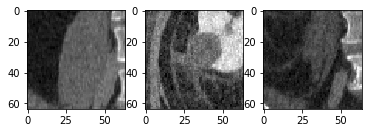

In [45]:
#for all x,y of test image 
lin_offx, lin_offy = np.meshgrid(np.linspace(0+32,220+32,55).astype('int'), np.linspace(0+32,220+32,55).astype('int'))



fileniiseg = 'test_im.nii.gz'
img_filename = os.path.join('/home/heinrich/notebooks/',fileniiseg)
img = nib.load(img_filename)
data_img = img.get_data()
data_img = np.flipud(np.fliplr(np.transpose(np.clip(data_img,0,1500.0)/1500.0)))
img_test = data_img +  np.random.randn(320,312)*0.01
   
patch2 = dataA[51,0,:,:].numpy()    #510 #3001
data=scipy.io.loadmat('trainingpts.mat')
train_pts = data.get('train_pts')
train_nu = 1
train_key = 16
print(train_pts[train_key,:,train_nu])
x1 = 320-train_pts[train_key,1,train_nu]
y1 = 312-train_pts[train_key,0,train_nu]
patch2 = imgs[x1-32:x1+32,y1-32:y1+32,train_nu]

net.cuda()
net.eval()
inputA1 = torch.from_numpy(patch2).contiguous().view(1,1,64,64).float()
inputA = Variable(inputA1.expand(55,1,64,64)).cuda()

i=54
j=54
patch1 = img_test[lin_offx[i,j]-32:lin_offx[i,j]+32,lin_offy[i,j]-32:lin_offy[i,j]+32]
print(patch1.shape)

r = np.corrcoef(patch1.reshape(1,-1),patch2.reshape(1,-1))
print(r)


simMap = np.zeros((55,55))
simMap2 = np.zeros((55,55))
simMap_L1 = np.zeros((55,55))
lowres = np.zeros((55,55))
for i in range(55):
    dataB_test = np.zeros((55,1,64,64))
    #print(i)
    for j in range(55):
        #print((x1,x2))
        #print((y1,y2))
        patch1 = img_test[lin_offx[i,j]-32:lin_offx[i,j]+32,lin_offy[i,j]-32:lin_offy[i,j]+32]
        img_small = img_test[lin_offx[i,j]-4:lin_offx[i,j]+4,lin_offy[i,j]-4:lin_offy[i,j]+4]
        #print(patch1.shape)
        r = np.corrcoef(patch1.reshape(1,-1),patch2.reshape(1,-1))
        simMap_L1[j,i] = np.mean(np.abs(patch2-patch1))# 
        #simMap_L1[j,i] = -r[0,1]

        lowres[j,i]=np.mean(img_small)
        dataB_test[j,0,:,:] = patch1 #torch.from_numpy(patch1).contiguous().float()
    inputB = Variable(torch.from_numpy(dataB_test).float()).cuda()
    outputs = net(inputA,inputB)
    out1 = outputs[1].data.view(55,-1).cpu().numpy()
    out2 = outputs[2].data.view(55,-1).cpu().numpy()
    
    for j in range(55):
        r = np.corrcoef(out1[j,:],out2[j,:])
        simMap[j,i] = r[0,1]
    res = torch.mean(torch.mean(torch.mean(torch.abs(outputs[1]-outputs[2]),dim=3),dim=2),dim=1)
    
    simMap2[:,i] = res.data.cpu().numpy()
    
#print(torch.mean(torch.abs(outputs[1]-outputs[2])))
print('done')

xy_simMap2 = np.unravel_index(simMap2.argmin(), simMap2.shape)
y1 = lin_offx[xy_simMap2[0],xy_simMap2[1]]
x1 = lin_offy[xy_simMap2[0],xy_simMap2[1]]
patch_simMap2 = img_test[x1-32:x1+32,y1-32:y1+32]
print((x1,y1))
#plt.imshow(patch_simMap2,'gray')
#plt.imshow(simMap2)
#plt.imshow(simMap_L1)
#plt.imshow(lowres)

xy_simMap_L1 = np.unravel_index(simMap_L1.argmin(), simMap_L1.shape)
y1 = lin_offx[xy_simMap_L1[0],xy_simMap_L1[1]]
x1 = lin_offy[xy_simMap_L1[0],xy_simMap_L1[1]]
patch_L1 = img_test[x1-32:x1+32,y1-32:y1+32]


f, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(patch2,'gray')
ax2.imshow(patch_simMap2,'gray')
ax3.imshow(patch_L1,'gray')
plt.show()

In [34]:
print(rand_img[3005])
print((rand_offx[3005],rand_offy[3005]))

1
(60, 43)


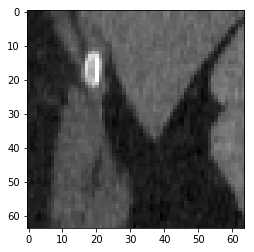

In [38]:
i = 3005
#patch1_train = imgs[rand_offx[i]:rand_offx[i]+64,rand_offy[i]:rand_offy[i]+64,rand_img[i]] 
patch1_train = imgs[60:60+64,43:43+64,1] 

#+ np.random.randn(64,64)*0.01
plt.imshow(patch1_train,'gray')
plt.show()

[89 55]
(320, 312, 9)


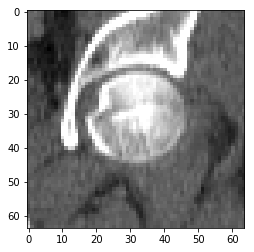

In [44]:
data=scipy.io.loadmat('trainingpts.mat')
train_pts = data.get('train_pts')
print(train_pts[12,:,1])
print(imgs.shape)
x1 = 320-55
y1 = 312-89
plt.imshow(imgs[x1-32:x1+32,y1-32:y1+32,1],'gray')
plt.show()
#seg_crop = data.get('segTrain')-1

In [ ]:
#rand_offx = np.random.randint(10,170,size=num)
#rand_offy = np.random.randint(10,170,size=num)
#rand_label = np.random.randint(0,4,size=num)
#rand_jitx = np.random.randint(0,2,size=num)
#rand_jity = np.random.randint(0,2,size=num)##

#rand_img = np.random.randint(0,9,size=num)

